<a href="https://colab.research.google.com/github/KR-0822/PolarBear/blob/main/KNN_%EC%97%AC%EB%A6%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리 및 데이터셋 생성

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
/content/drive/MyDrive/GarbageClassification

In [ ]:
import torch
 
torch.cuda.is_available() 

True

In [ ]:
fn = pd.read_csv('/content/drive/MyDrive/해빙/data_v2/train_v2.csv')
fn.tail() # 데이터가 2019년까지임을 확인

,month,file_nm
489,2019-08,201908.npy
490,2019-09,201909.npy
491,2019-10,201910.npy
492,2019-11,201911.npy
493,2019-12,201912.npy


In [ ]:
dm = fn.iloc[:, 1] # 1978년 - 2019년 데이터 불러오기
dm

0      197811.npy
1      197812.npy
2      197901.npy
3      197902.npy
4      197903.npy
          ...    
489    201908.npy
490    201909.npy
491    201910.npy
492    201911.npy
493    201912.npy
Name: file_nm, Length: 494, dtype: object

In [ ]:
DIR_TRAIN_PATH = '/content/drive/MyDrive/해빙/data_v2/train_data_v2/'
order = pd.read_csv('/content/drive/MyDrive/해빙/data_v2/train_v2.csv')
total_data = np.load(DIR_TRAIN_PATH + order['file_nm'][0])
total_data = total_data.reshape(1,448, 304, 5)

for i in tqdm(range(0, order.shape[0])):
    tmp = np.load(DIR_TRAIN_PATH + order['file_nm'][i])
    tmp = tmp.reshape(1,448, 304, 5)

    total_data = np.concatenate((total_data, tmp), axis = 0)

total_data = np.array(total_data)
np.save('/content/drive/MyDrive/해빙/total_data.npy', total_data)

100%|██████████| 494/494 [00:21<00:00, 22.57it/s]


In [ ]:
# total_data.shape # 고치기

(495, 448, 304, 5)

In [ ]:
total_data = total_data[:, :, :, 0]
total_data.shape # (495, 448, 304)

(495, 448, 304)

In [ ]:
# 월별 데이터셋 만들기(사계절 중, 여름에 가장 해빙 감소가 뚜렷하여 매년 7월 데이터만 사용)
july = 8 # fn['file_nm'][8] == '197907.npy'
total_data = total_data.reshape(495, 1, 448, 304)

summer = np.array(total_data[july])


for i in tqdm(range(40)):
  summer = np.array(np.concatenate((summer, total_data[july + 12 * (i + 1)])))

summer.shape # (41, 448, 304)
np.save('/content/drive/MyDrive/해빙/summer.npy', summer)

100%|██████████| 40/40 [00:00<00:00, 1088.36it/s]


In [ ]:
# 북극점 채우기(미리 했어야 하는걸...)
pole = np.load('/content/drive/MyDrive/해빙/total_data.npy')
pole = pole[:, :, :, 1]
np.save('/content/drive/MyDrive/해빙/pole.npy', pole)

In [ ]:
# pole.shape (495, 448, 304)

In [ ]:
pole = pole.reshape(495, 1, 448, 304)
pole_summer = np.array(pole[july])

for i in tqdm(range(40)):
  pole_summer = np.array(np.concatenate((pole_summer, pole[july + 12 * (i + 1)])))

pole_summer.shape # (41, 448, 304)

100%|██████████| 40/40 [00:00<00:00, 877.92it/s]


(41, 448, 304)

In [ ]:
summer = np.load('/content/drive/MyDrive/해빙/summer.npy')

In [ ]:
summer = np.load('/content/drive/MyDrive/해빙/summer.npy')
summer = summer + pole_summer * 250

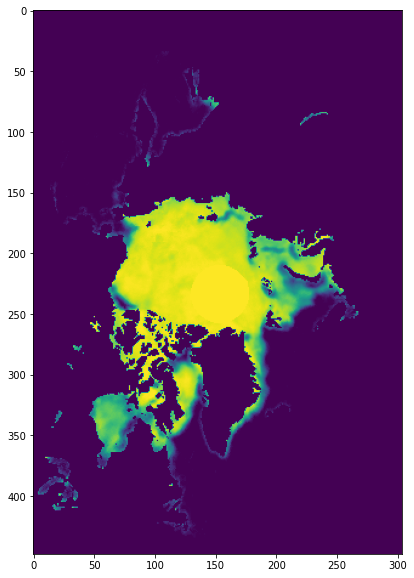

In [ ]:
# 북극점 채워진 모습 확인
plt.figure(figsize =  (10, 10))  
plt.imshow(summer[0, :, :])
np.save('/content/drive/MyDrive/해빙/summer_plus_pole', summer) # 최종 학습데이터(1979 - 2019년 7월 & 북극점 포함)

In [ ]:
summer_sum = summer.sum(axis = 1)
summer_sum = summer_sum.sum(axis = 1)
pd.DataFrame(summer_sum)

,0
0,4193477
1,4053214
2,4064052
3,4232137
4,4165530
5,4097732
6,4046119
7,4047860
8,4209483
9,3979156


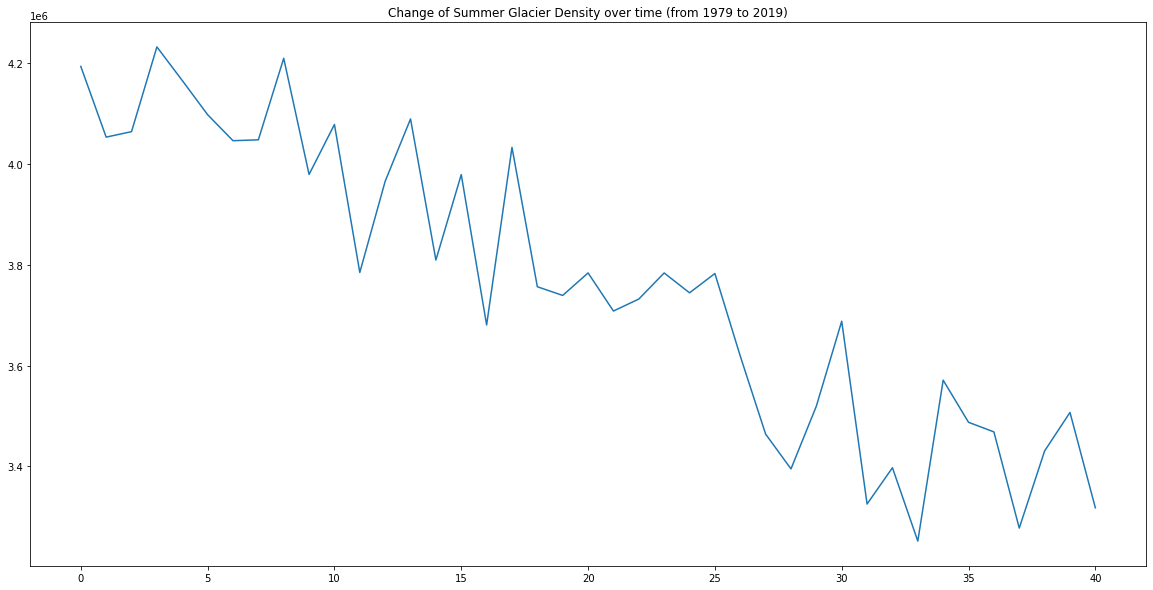

In [ ]:
summer_density = []
summer_density = pd.DataFrame(summer.sum(axis = 1))

plt.figure(figsize = (20,10))
plt.title('Change of Summer Glacier Density over time (from 1979 to 2019)')

#x_label = []
#for i in range(1979, 2020):
#  x_label.append(i)

plt.plot(summer_sum)
plt.show()

# 훈련

In [ ]:
# 대회 점수 산출식 그대로 이용
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)<250*0.5)
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

def fun1(x) : 
  return np.around(x,2)

In [ ]:
x_train = summer[0:39].reshape(39, -1).T
y_train = summer[39].reshape(1, -1).T
x_test = summer[1:40].reshape(39, -1).T
y_test = summer[40].reshape(1, -1).T

from sklearn.neighbors import KNeighborsRegressor

num = [580, 590, 600, 610, 620, 630] # 최적의 k를 찾는 시도
for k in tqdm(num):
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 1, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))

  0%|          | 0/6 [00:00<?, ?it/s]

num: 580


 17%|█▋        | 1/6 [07:25<37:08, 445.62s/it]

MAE : 4.305303174929511 
 F1 : 0.9439945437586047 
 Final 4.56072882813522
num: 590


 33%|███▎      | 2/6 [14:53<29:46, 446.67s/it]

MAE : 4.308191964285714 
 F1 : 0.9439945437586047 
 Final 4.563789004006681
num: 600


 50%|█████     | 3/6 [22:18<22:18, 446.28s/it]

MAE : 4.3113671140742476 
 F1 : 0.943849740845741 
 Final 4.5678532099108216
num: 610


 67%|██████▋   | 4/6 [29:44<14:51, 445.84s/it]

MAE : 4.314141726386278 
 F1 : 0.9437578044292725 
 Final 4.571238150748673
num: 620


 83%|████████▎ | 5/6 [36:54<07:20, 440.16s/it]

MAE : 4.317028826950187 
 F1 : 0.9437514994281189 
 Final 4.574327864721678
num: 630


100%|██████████| 6/6 [44:02<00:00, 440.39s/it]

MAE : 4.320188483905075 
 F1 : 0.9434712382460719 
 Final 4.5790356536422


In [ ]:
x_train = summer[0:39].reshape(39, -1).T
y_train = summer[39].reshape(1, -1).T
x_test = summer[1:40].reshape(39, -1).T
y_test = summer[40]

num = [650, 700, 750, 800, 850] #  최적의 k를 찾는 시도

for k in tqdm(num):
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 1, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))

  0%|          | 0/5 [00:00<?, ?it/s]

num: 650


 20%|██        | 1/5 [07:09<28:36, 429.21s/it]

MAE : 4.3255848361137215 
 F1 : 0.9434712382460719 
 Final 4.5847553321365675
num: 700


 40%|████      | 2/5 [14:23<21:37, 432.48s/it]

MAE : 4.338430304276315 
 F1 : 0.9431253609762754 
 Final 4.600056829968843
num: 750


 60%|██████    | 3/5 [21:39<14:27, 433.87s/it]

MAE : 4.351125616776316 
 F1 : 0.9427065044838207 
 Final 4.615567570527267
num: 800


 80%|████████  | 4/5 [28:52<07:13, 433.56s/it]

MAE : 4.363029546522556 
 F1 : 0.9421593421229096 
 Final 4.630882808403494
num: 850


100%|██████████| 5/5 [36:09<00:00, 433.88s/it]

MAE : 4.374744258106204 
 F1 : 0.9418065809379951 
 Final 4.64505589597665


In [ ]:
x_train = summer[0:39].reshape(39, -1).T
y_train = summer[39].reshape(1, -1).T
x_test = summer[1:40].reshape(39, -1).T
y_test = summer[40]


num = [300, 350, 400, 450, 500] #  최적의 k를 찾는 시도

for k in tqdm(num):
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 1, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))

  0%|          | 0/5 [00:00<?, ?it/s]

num: 300


 20%|██        | 1/5 [07:18<29:15, 438.83s/it]

MAE : 4.202859272203947 
 F1 : 0.9465904502059809 
 Final 4.439997495104051
num: 350


 40%|████      | 2/5 [14:38<21:57, 439.11s/it]

MAE : 4.224315745418233 
 F1 : 0.946237083879206 
 Final 4.464331162605529
num: 400


 60%|██████    | 3/5 [21:59<14:39, 439.94s/it]

MAE : 4.244533819901315 
 F1 : 0.9459511642423266 
 Final 4.487053809411502
num: 450


 80%|████████  | 4/5 [29:19<07:20, 440.12s/it]

MAE : 4.2631391711701125 
 F1 : 0.9456682224119171 
 Final 4.508070616157868
num: 500


100%|██████████| 5/5 [36:21<00:00, 436.35s/it]

MAE : 4.28020390331297 
 F1 : 0.9449311920182996 
 Final 4.529646067534639


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {DIR_NAME}

In [ ]:
x_train = summer[0:39].reshape(39, -1).T
y_train = summer[39].reshape(1, -1).T
x_test = summer[1:40].reshape(39, -1).T
y_test = summer[40]

num = [300, 350] # 최적의 k를 찾는 시도

for k in tqdm(num):
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 2, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))

  0%|          | 0/2 [00:00<?, ?it/s]

num: 300


 50%|█████     | 1/2 [04:16<04:16, 256.52s/it]

MAE : 4.126938219572367 
 F1 : 0.9444366469643988 
 Final 4.369735322257759
num: 350


100%|██████████| 2/2 [08:33<00:00, 256.76s/it]

MAE : 4.142194402020676 
 F1 : 0.9438513800710753 
 Final 4.38860867886072


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


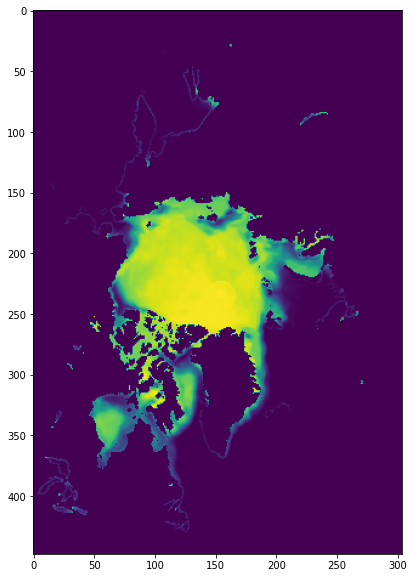

NameError: ignored

In [ ]:
# 여기부터 다시 시작
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor

from google.colab import drive
drive.mount('/content/drive')

summer_plus_pole = np.load('/content/drive/MyDrive/해빙/summer_plus_pole.npy')

x_train = summer_plus_pole[20:39].reshape(19, -1).T # 데이터를 1979 - 2018에서 1998 - 2018로 줄임(1878 - 1997 감소 경향이 매끄럽지 않아서.)
y_train = summer_plus_pole[39].reshape(1, -1).T
x_test = summer_plus_pole[21:40].reshape(19, -1).T
y_test = summer_plus_pole[40]


model = KNeighborsRegressor(n_neighbors = 300, weights = 'distance', p = 2, n_jobs = -1) #  최적의 k를 찾는 시도
model.fit(x_train, y_train)

predictions = model.predict(x_test)
predictions = predictions.reshape(-1)

predictions = predictions.reshape(448, 304)
plt.figure(figsize = (20, 10))
plt.imshow(predictions)
plt.show()

print()
print()
print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
       '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
      '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))

In [ ]:
predictions = predictions.reshape(-1)
print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(predictions)),
       '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(predictions)),
      '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(predictions)))

MAE : 3.8971720805921053 
 F1 : 0.9466721940064525 
 Final 4.11670699118313


  0%|          | 0/7 [00:00<?, ?it/s]

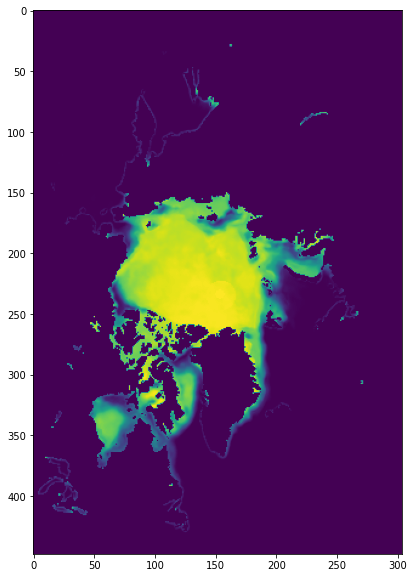

 14%|█▍        | 1/7 [04:25<26:33, 265.65s/it]



MAE : 3.8985550546287593 
 F1 : 0.9467607387039024 
 Final 4.117782723846344


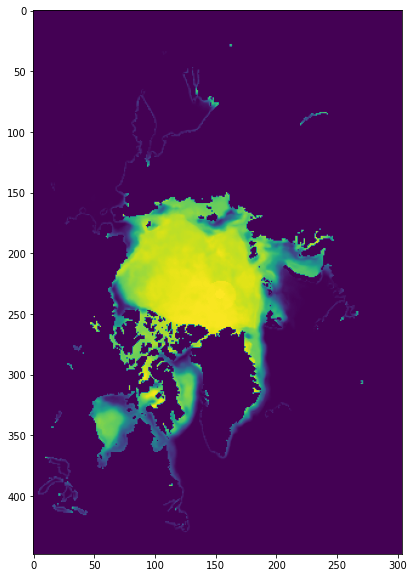

 29%|██▊       | 2/7 [08:53<22:13, 266.78s/it]



MAE : 3.8978498002819553 
 F1 : 0.9467607387039024 
 Final 4.117037810891546


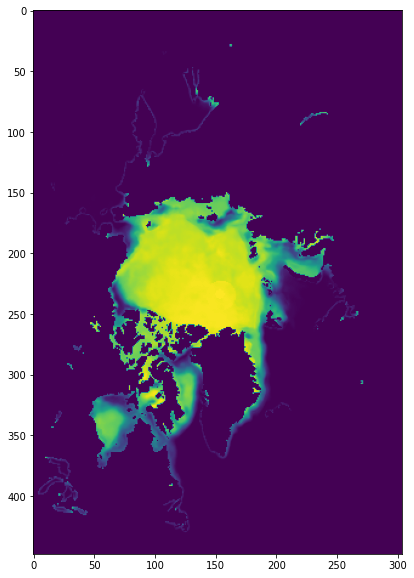

 43%|████▎     | 3/7 [13:19<17:46, 266.68s/it]



MAE : 3.897336921405076 
 F1 : 0.9467252541262002 
 Final 4.116650383257918


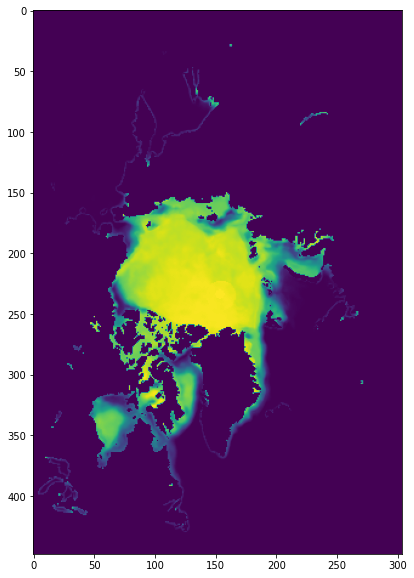

 57%|█████▋    | 4/7 [17:48<13:21, 267.30s/it]



MAE : 3.897091532542293 
 F1 : 0.9465571068420034 
 Final 4.117122425262779


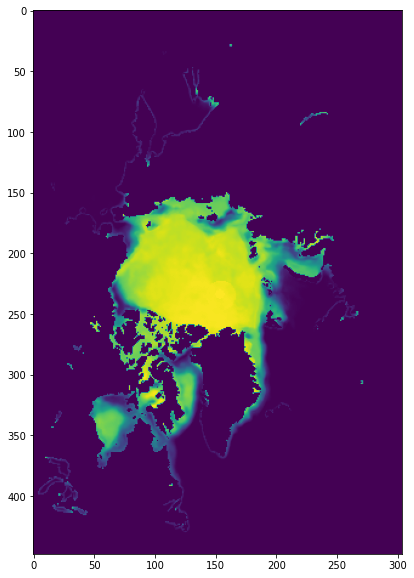

 71%|███████▏  | 5/7 [22:15<08:55, 267.53s/it]



MAE : 3.8974054276315795 
 F1 : 0.9465866282748027 
 Final 4.117325630895


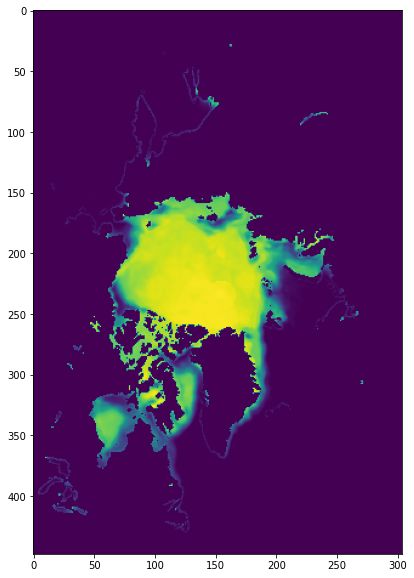

 86%|████████▌ | 6/7 [26:42<04:27, 267.25s/it]



MAE : 3.897728868068609 
 F1 : 0.9466396850855617 
 Final 4.117436537157164


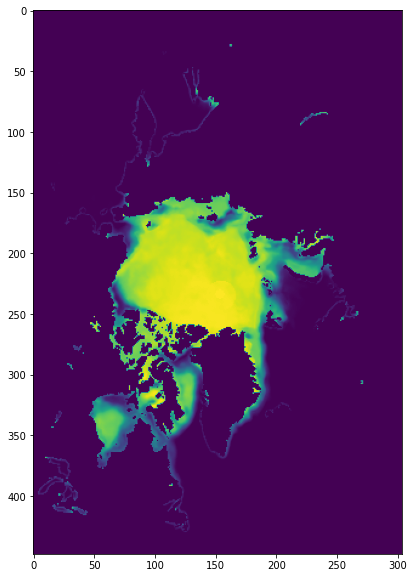

100%|██████████| 7/7 [31:09<00:00, 267.06s/it]



MAE : 3.898705136865601 
 F1 : 0.9463654442624856 
 Final 4.119661299242913


In [ ]:
x_train = summer_plus_pole[20:39].reshape(19, -1).T
y_train = summer_plus_pole[39].reshape(1, -1).T
x_test = summer_plus_pole[21:40].reshape(19, -1).T
y_test = summer_plus_pole[40]

num = [270, 280, 290, 310, 320, 330, 340] # k = 310일때가 최적의 k

for k in tqdm(num):
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 2, n_jobs = -1)
  model.fit(x_train, y_train)

  predictions = model.predict(x_test)
  predictions = predictions.reshape(448, 304)
  plt.figure(figsize = (20, 10))
  plt.imshow(predictions)
  plt.show()

  print()
  print()
  predictions = predictions.reshape(-1)
  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(predictions)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(predictions)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(predictions)))